# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **GODAS**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.d80a6125268f4df79d87dab13e2d86e7 Dashboard: /services/dask-gateway/clusters/prod.d80a6125268f4df79d87dab13e2d86e7/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [122]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [4]:
xr.set_options(display_style='text')

In [5]:
path = 'pangeo-tmp/stb2145/GODAS/datasets/'
ds = xr.open_zarr(gcsfs.GCSMap(path + 'ds_wg.zarr'))
coords = xr.open_zarr(gcsfs.GCSMap(path + 'coords_wg.zarr'))
cell_coords = xr.open_zarr(gcsfs.GCSMap(path + 'cell_coords_wg.zarr'))
cell_elements = xr.open_zarr(gcsfs.GCSMap(path + 'cell_elements_wg.zarr'))
surf_flux_conv = xr.open_zarr(gcsfs.GCSMap(path + 'surf_flux_conv.zarr'))
total_tend = xr.open_zarr(gcsfs.GCSMap(path + 'total_tend.zarr'))
vel = xr.open_zarr(gcsfs.GCSMap(path + 'vel.zarr'))

In [6]:
fs = gcsfs.GCSFileSystem(requester_pays=True)
mapping = fs.get_mapper('gs://pangeo-ncep-godas')
globe = xr.open_zarr(mapping, consolidated=True)

In [7]:
#slicing datasets to finish Feb 1, 2019 so that time will line up at dVdt section 
ds = ds.isel(time=slice(0, -1))
surf_flux_conv = surf_flux_conv.isel(time=slice(0,-1))

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [8]:
temp = (ds.pottmp - 273.15).load() #K to C
salt = (ds.salt * 1000).load() #kg/kg to g/kg

In [9]:
pref = 2000

In [10]:
ds.pottmp.coords

Coordinates:
  * lat      (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * level    (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -65.5 -64.5 -63.5 -62.5 -61.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [11]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, salt, temp, pref,
                            output_dtypes=[salt.dtype],
                            dask='parallelized').reset_coords(drop=True).load()

In [12]:
sigma2 = sigma2[:,1:,1:,1:]

In [13]:
sigma2.coords

Coordinates:
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

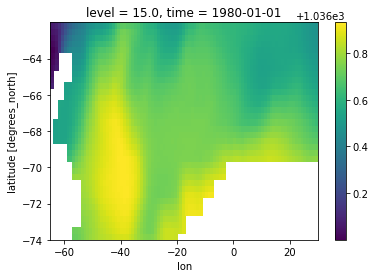

In [14]:
sigma2[0,0].plot()

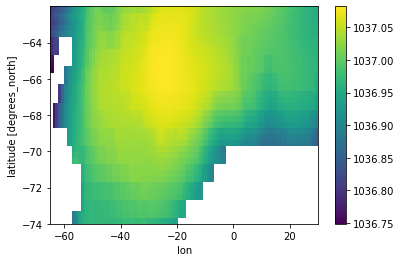

In [15]:
sigma2.mean(dim=['time', 'level']).plot()

(array([  7.,  18.,  15.,  42., 105., 192., 479., 589., 679., 568.]),
 array([1036.74868291, 1036.78204353, 1036.81540415, 1036.84876478,
        1036.8821254 , 1036.91548602, 1036.94884664, 1036.98220727,
        1037.01556789, 1037.04892851, 1037.08228913]),
 <BarContainer object of 10 artists>)

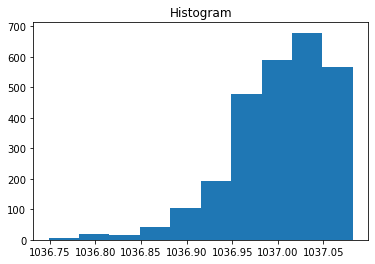

In [16]:
sigma2.mean(dim=['time', 'level']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [19]:
cell_coords.cell_volume_wg[:-1, :-1, :].coords

Coordinates:
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

In [17]:
total_tend.totttend.coords

Coordinates:
  * lat      (lat) float64 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float64 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

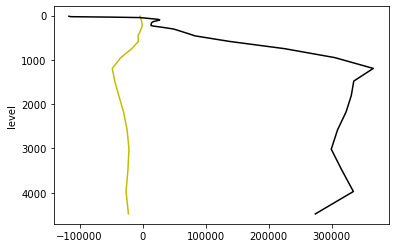

In [20]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9

vol = cell_coords.cell_volume_wg[:-1, :-1, :]
((delta_sigma * vol).sum(dim=['lat', 'lon'])/ total_time).plot(y='level', yincrease=False, color='y')
(total_tend.totttend[1:] + total_tend.totstend).sum(dim=['lat', 'lon']).mean(dim='time').plot(y='level', yincrease=False, color='k')

# Why does vol and total tend not match??

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

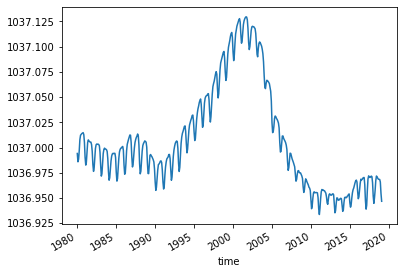

In [21]:
#looks strange but it's similar to ECCO considering the shorter time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.mean(dim=['lon', 'lat', 'level']).plot()

In [29]:
sigma2.min().values

array(1035.62501688)

In [30]:
sigma2.max().values

array(1037.28606099)

In [22]:
# define bins (make same as ECCO & SOSE)
delta_sigma = 0.01
sigma_bins = np.arange(1027.5, 1037.5, delta_sigma)

In [23]:
sigma_bins.size

1000

In [24]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol, dim=['lon', 'lat', 'level']).load()

In [25]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 470, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

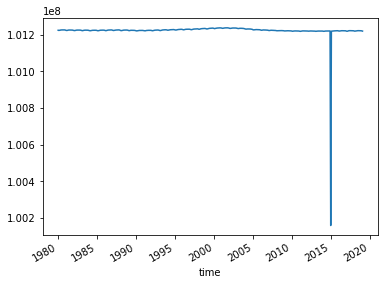

In [52]:
sigma2.sum(dim=['lon', 'lat', 'level']).plot()

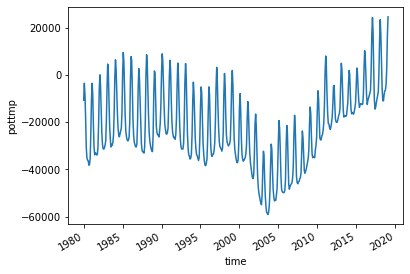

In [53]:
temp.sum(dim=['lon', 'lat', 'level']).plot()

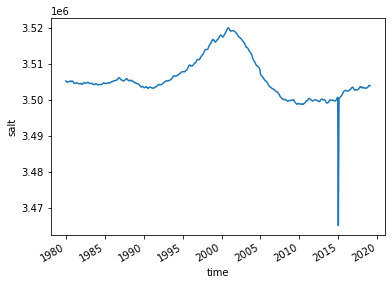

In [54]:
salt.sum(dim=['lon', 'lat', 'level']).plot()

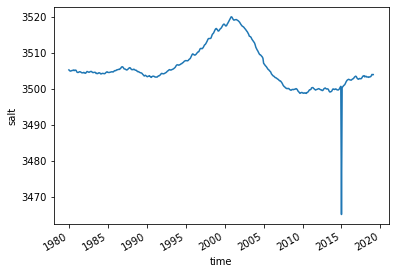

In [57]:
ds.salt.sum(dim=['lon', 'lat', 'level']).plot()

In [65]:
salt.min()

<xarray.DataArray 'salt' ()>
array(33.03781128)

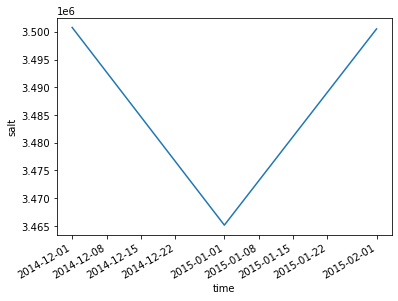

In [75]:
salt.sel(time=slice('2014-12', '2015-02')).sum(dim=['lon', 'lat', 'level']).plot()

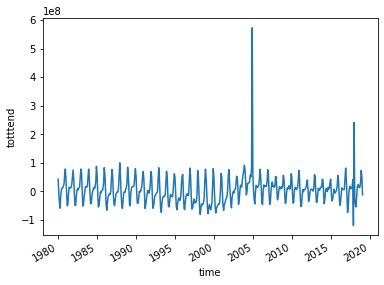

In [81]:
total_tend.totttend.sum(dim=['lon', 'lat', 'level']).plot()

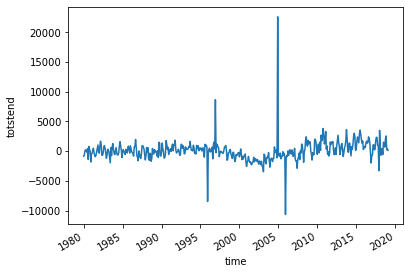

In [80]:
total_tend.totstend.sum(dim=['lon', 'lat', 'level']).plot()

In [77]:
salt.sel(time=slice('2014-12', '2015-02')).min()

<xarray.DataArray 'salt' ()>
array(33.22702789)

(1036.9, 1037.3)

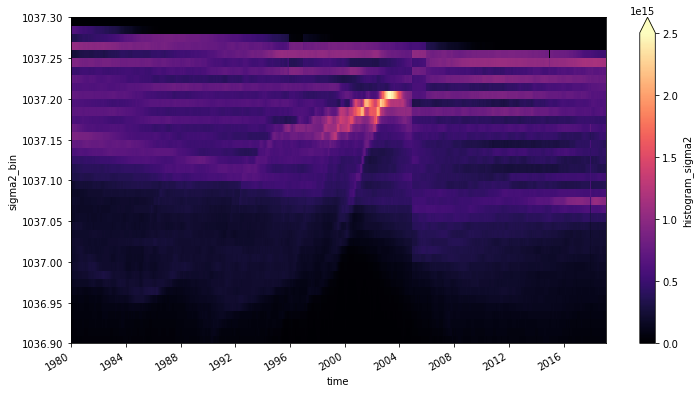

In [26]:
sigma_dist.plot(x='time', figsize=(12, 6), vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3)

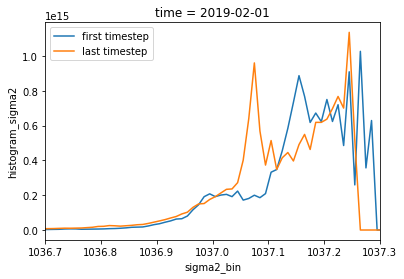

In [27]:
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

(1037.5, 1036.4)

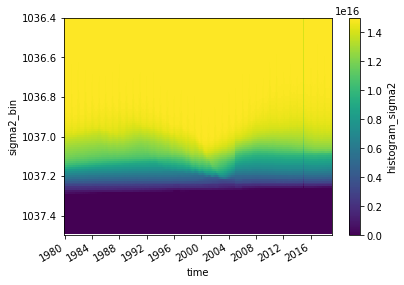

In [28]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(1037.5, 1036.4)

In [29]:
V

<xarray.DataArray 'histogram_sigma2' (time: 470, sigma2_bin: 999)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.49891108e+16, 1.49891108e+16, 1.49891108e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.49891108e+16, 1.49891108e+16, 1.49891108e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.49891108e+16, 1.49891108e+16, 1.49891108e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.49891108e+16, 1.49891108e+16, 1.49891108e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.49891108e+16, 1.49891108e+16, 1.49891108e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.49891108e+16, 1.49891108e+16, 1.49891108e+16]])
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1037.5, 1036.5)

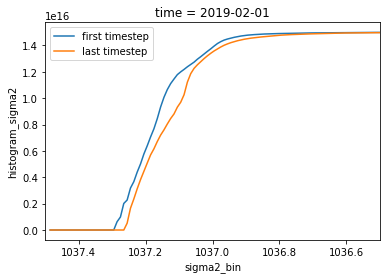

In [30]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1036.5)

In [31]:
delta_V = V.diff(dim='time')

In [32]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

In [33]:
coords.dt[1:-1]

<xarray.DataArray 'dt' (time: 469)>
dask.array<getitem, shape=(469,), dtype=float32, chunksize=(469,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

## $\frac{\partial \mathcal{V}}{\partial t}$

In [34]:
dVdt = delta_V / coords.dt[1:-1]

In [35]:
dVdt

<xarray.DataArray (time: 469, sigma2_bin: 999)>
dask.array<true_divide, shape=(469, 999), dtype=float64, chunksize=(469, 999), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

(1035.5, 1037.3)

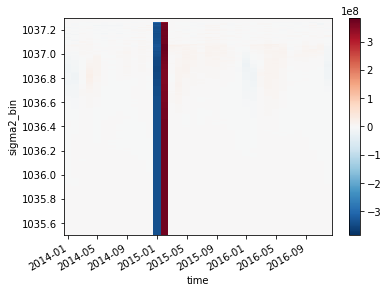

In [36]:
dVdt.sel(time=slice('2014', '2016')).plot(x='time')
plt.ylim(1035.5, 1037.3)

## $\Omega_{total}$

In [50]:
total_tend.totttend.coords

Coordinates:
  * lat      (lat) float64 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float64 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [51]:
sigma2.coords

Coordinates:
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [38]:
omega_total_th = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=total_tend.totttend.fillna(0.),
                          dim=['lat', 'lon', 'level']) / (- delta_sigma)
omega_total_th.load()

omega_total_slt = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=total_tend.totstend.fillna(0.),
                          dim=['lat', 'lon', 'level']) / (-delta_sigma)
omega_total_slt.load()

omega_total = omega_total_th + omega_total_slt
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 470, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [39]:
#same time length as dVdt
omega_total = omega_total[1:]
omega_total_th = omega_total_th[1:]
omega_total_slt = omega_total_slt[1:]

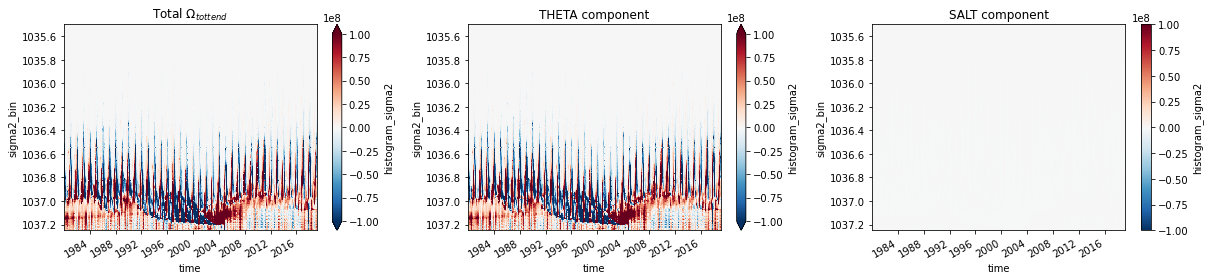

In [47]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymin=1037.25, ymax=1035.5)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymin=1037.25, ymax=1035.5)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymin=1037.25, ymax=1035.5)
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

In [56]:
dVdt.coords

Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

In [57]:
omega_total.coords

Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

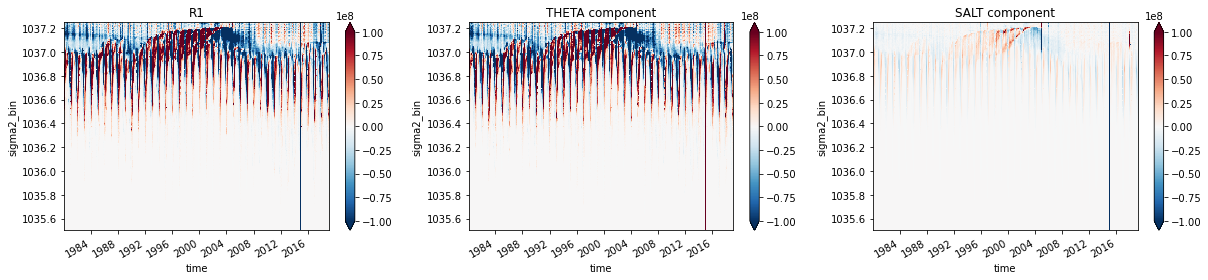

In [82]:
R1 = dVdt - omega_total
R1_th = dVdt - omega_total_th
R1_slt = dVdt - omega_total_slt

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymax=1037.25, ymin=1035.5)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymax=1037.25, ymin=1035.5)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25, ymin=1035.5)
ax2.set_title('SALT component')

plt.tight_layout();

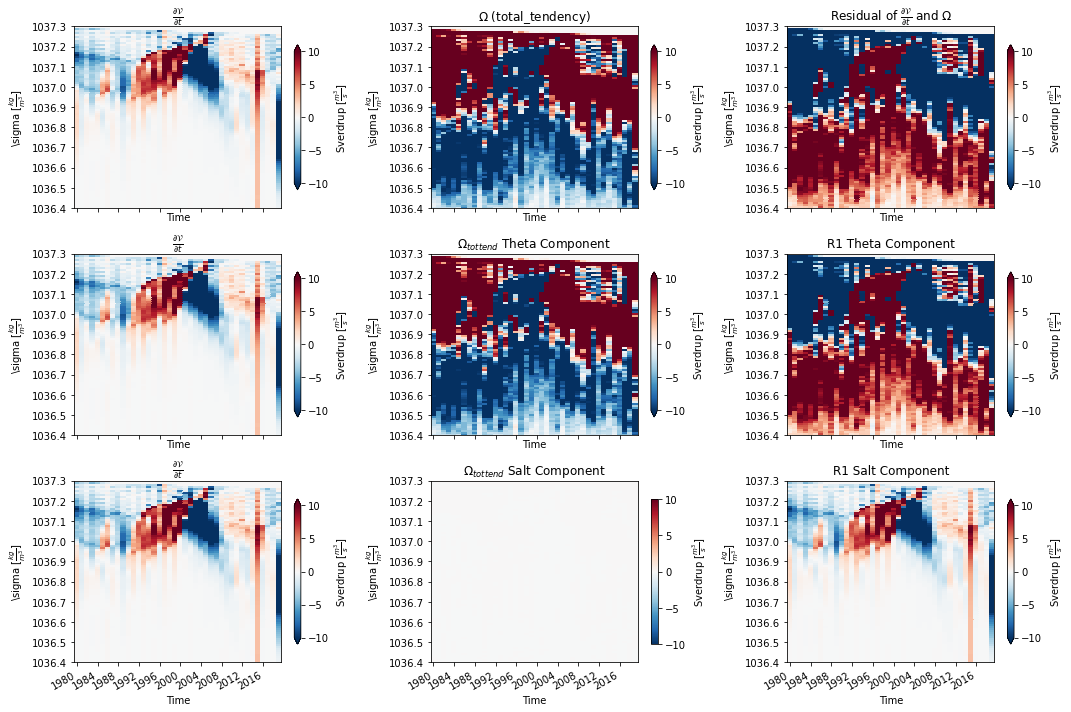

In [83]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
axes[0,0].set_xlabel('Time')#, fontsize=14)
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
axes[0,0].set_ylim(1036.4, 1037.3)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')#, fontsize=14)
axes[0,1].set_title('$\Omega$ (total_tendency)')
axes[0,1].set_ylim(1036.4, 1037.3)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
axes[0,2].set_ylim(1036.4, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
axes[1,0].set_ylim(1036.4, 1037.3)

(omega_total_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title(r'$\Omega_{tottend}$ Theta Component')
axes[1,1].set_ylim(1036.4, 1037.3)

(R1_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')#, fontsize=14)
axes[1,2].set_title(r'R1 Theta Component')
axes[1,2].set_ylim(1036.4, 1037.3)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')
axes[2,0].set_ylim(1036.4, 1037.3)

(omega_total_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title(r'$\Omega_{tottend}$ Salt Component')
axes[2,1].set_ylim(1036.4, 1037.3)

(R1_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')#, fontsize=14)
axes[2,2].set_title(r'R1 Salt Component')
axes[2,2].set_ylim(1036.4, 1037.3)

plt.tight_layout();

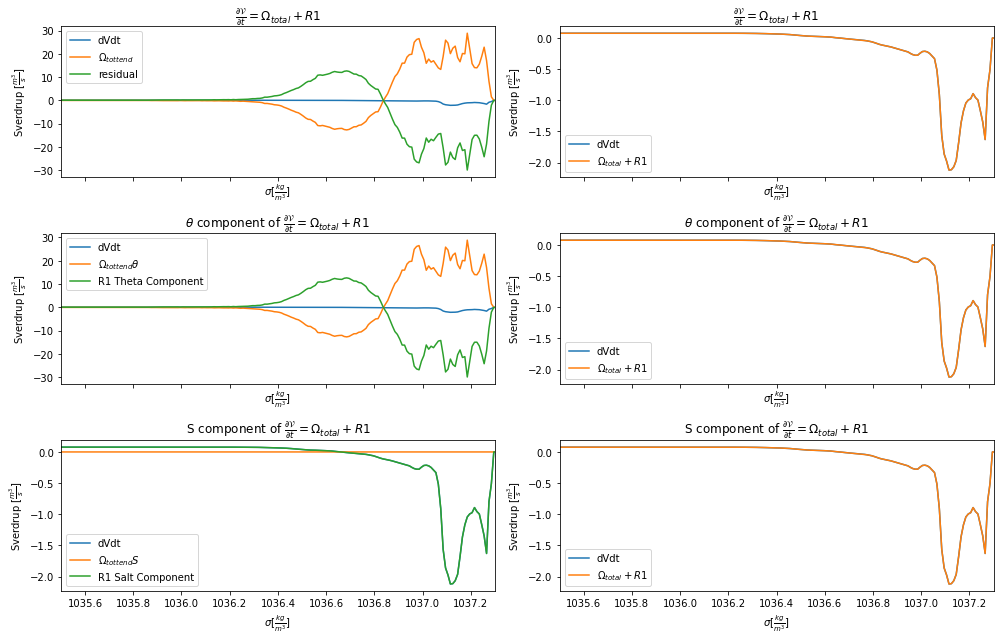

In [84]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
axes[1,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[1,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,1].set_xlim(1035.5, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{surf} \end{equation*}

In [95]:
surf_flux_conv.load()

<xarray.Dataset>
Dimensions:             (lat: 36, level: 40, lon: 95, time: 470)
Coordinates:
  * lat                 (lat) float32 -73.83 -73.5 -73.17 ... -62.5 -62.17
  * level               (level) float32 5.0 15.0 25.0 ... 3.972e+03 4.478e+03
  * lon                 (lon) float64 -64.5 -63.5 -62.5 -61.5 ... 27.5 28.5 29.5
  * time                (time) datetime64[ns] 1980-01-01 ... 2019-02-01
Data variables:
    surf_flux_conv_SLT  (time, level, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    surf_flux_conv_TH   (time, level, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0

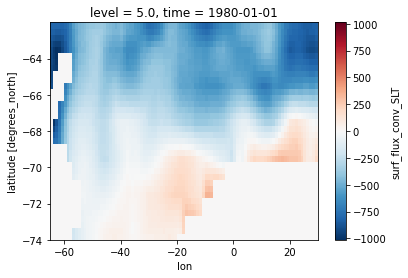

In [87]:
surf_flux_conv.surf_flux_conv_SLT[0,0].plot()

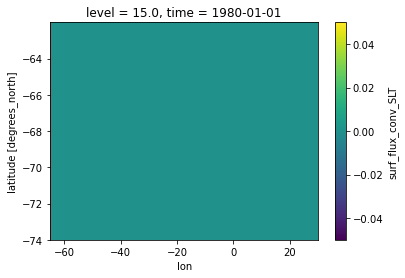

In [88]:
surf_flux_conv.surf_flux_conv_SLT[0,1].plot()

In [89]:
surf_flux_conv.surf_flux_conv_SLT[:, 1, :, :]

<xarray.DataArray 'surf_flux_conv_SLT' (time: 470, lat: 36, lon: 95)>
dask.array<getitem, shape=(470, 36, 95), dtype=float32, chunksize=(12, 36, 95), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -73.83 -73.5 -73.17 -72.83 ... -62.83 -62.5 -62.17
    level    float32 15.0
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01

In [96]:
#giving level's 2nd index surface values since all other terms start at 15m instead of 5m
surf_flux_conv.surf_flux_conv_SLT[:, 1, :, :] = surf_flux_conv.surf_flux_conv_SLT[:, 0, :, :].values
surf_flux_conv.surf_flux_conv_TH[:, 1, :, :] = surf_flux_conv.surf_flux_conv_TH[:, 0, :, :].values

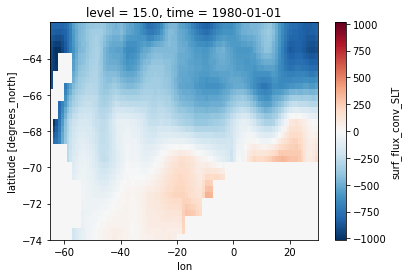

In [97]:
surf_flux_conv.surf_flux_conv_SLT[0,1].plot()

In [101]:
omega_surf_TH = - (histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=surf_flux_conv.surf_flux_conv_TH[:,1:].fillna(0.), dim=['lon', 'lat', 'level']) / (-delta_sigma))
omega_surf_TH.load()

omega_surf_SLT = - (histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=surf_flux_conv.surf_flux_conv_SLT[:,1:].fillna(0.), dim=['lon', 'lat', 'level']) / (-delta_sigma))
omega_surf_SLT.load()

omega_surf = omega_surf_TH + omega_surf_SLT
omega_surf.load()

<xarray.DataArray 'histogram_sigma2' (time: 470, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

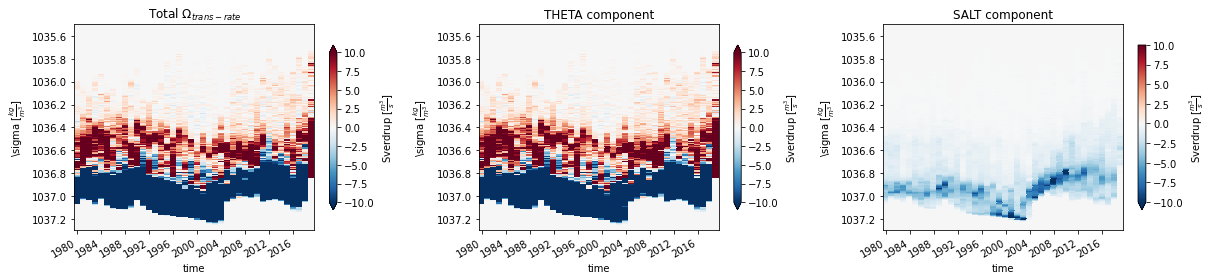

In [102]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_surf.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=10,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_surf_TH.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=10,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_surf_SLT.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=10,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'> \begin{equation*} NO\ \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} </font>

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \theta \end{equation*}</font>

In [104]:
import xgcm
grid = xgcm.Grid(ds, coords={'X': {'center': 'lon', 'right': 'lon_u'}, 
                             'Y': {'center': 'lat', 'right': 'lat_u'},
                             'T': {'center': 'time'},
                             'Z': {'center': 'level', 'right': 'level_w'}},
                     periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> right
  * right    lon_u --> center
Y Axis (not periodic, boundary=None):
  * center   lat --> right
  * right    lat_u --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   level --> right
  * right    level_w --> center

In [105]:
ds

<xarray.Dataset>
Dimensions:    (lat: 37, lat_u: 37, level: 40, level_w: 40, lon: 96, lon_u: 96, time: 470)
Coordinates:
  * lat        (lat) float32 -74.17 -73.83 -73.5 -73.17 ... -62.83 -62.5 -62.17
  * lat_u      (lat_u) float32 -74.0 -73.67 -73.33 -73.0 ... -62.67 -62.33 -62.0
  * level      (level) float32 5.0 15.0 25.0 ... 3.483e+03 3.972e+03 4.478e+03
  * level_w    (level_w) float32 10.0 20.0 30.0 ... 4.225e+03 4.736e+03
  * lon        (lon) float32 -65.5 -64.5 -63.5 -62.5 ... 26.5 27.5 28.5 29.5
  * lon_u      (lon_u) float32 -65.0 -64.0 -63.0 -62.0 ... 27.0 28.0 29.0 30.0
  * time       (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2019-02-01
Data variables:
    dbss_obil  (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    dbss_obml  (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    dzdt       (time, level_w, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    pottmp     (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    salt       (time, level, lat, lon) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    sltfl      (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    sshg       (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    thflx      (time, lat, lon) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    ucur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    uflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
    vcur       (time, level, lat_u, lon_u) float32 dask.array<chunksize=(4, 40, 37, 96), meta=np.ndarray>
    vflx       (time, lat_u, lon_u) float32 dask.array<chunksize=(12, 37, 96), meta=np.ndarray>
Attributes:
    Conventions:      COARDS
    References:       https://www.esrl.noaa.gov/psd/data/gridded/data.godas.html
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GODAS FILES.
    creation_date:    Sat Dec 16 20:00:00 MDT 2006
    dataset_title:    NCEP Global Ocean Data Assimilation System (GODAS)
    grib_file:        godas.M.198001-12.grb
    history:          Created 2006/12 by Hoop
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    title:            GODAS: Global Ocean Data Assimilation System

In [64]:
ucur_interp = grid.interp(ds.ucur, axis=['X', 'Y'], boundary='fill', keep_coords=True)
vcur_interp = grid.interp(ds.vcur, axis=['X', 'Y'], boundary='fill', keep_coords=True)

In [66]:
ucur_interp = ucur_interp[1:, 1:, 1:, 1:]
vcur_interp = vcur_interp[1:, 1:, 1:, 1:]

In [70]:
u_transport_right = (ucur_interp * cell_elements.dy[:-1] * cell_elements.dz).isel(lon=-1)
u_transport_left = (ucur_interp * cell_elements.dy[:-1] * cell_elements.dz).isel(lon=0)

v_transport = (vcur_interp * cell_elements.dx[:-1, :-1] * cell_elements.dz).isel(lat=-1)
#units: m^3/s

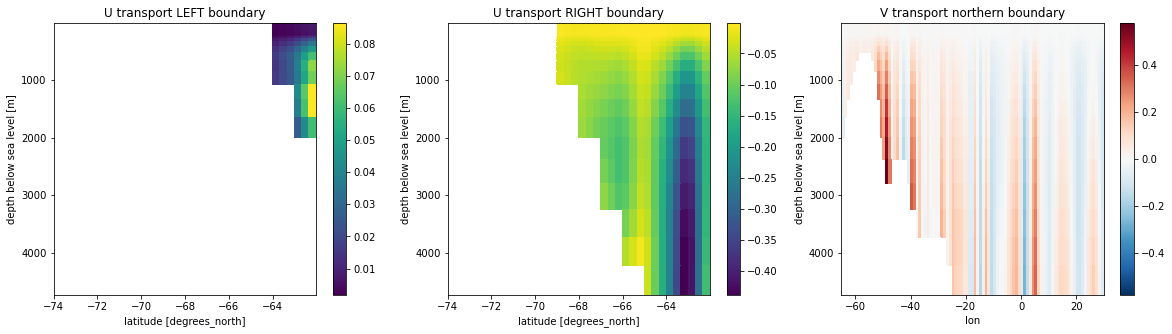

In [71]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(20,5))

(u_transport_left[0]/1e6).plot(yincrease=False, ax=ax0)
ax0.set_title('U transport LEFT boundary')
(u_transport_right[0]/1e6).plot(yincrease=False, ax=ax1) 
ax1.set_title('U transport RIGHT boundary')
(v_transport[0]/1e6).plot(yincrease=False, ax=ax2)
ax2.set_title('V transport northern boundary');

In [72]:
u_transport_mean_value = (u_transport_right.sum(dim=['lat', 'level']) -
                          u_transport_left.sum(dim=['lat', 'level'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-42.895523, dtype=float32)

In [73]:
v_transport_mean_value = (v_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(42.01839, dtype=float32)
Coordinates:
    lat      float32 -62.17

In [74]:
residual = u_transport_mean_value + v_transport_mean_value
residual

<xarray.DataArray ()>
array(-0.8771324, dtype=float32)
Coordinates:
    lat      float32 -62.17

In [75]:
sigma_at_u_right = sigma2.isel(lon=-1)
sigma_at_u_left = sigma2.isel(lon=0)
sigma_at_v = sigma2.isel(lat=-1)

In [88]:
sigma_at_v[1:].coords

Coordinates:
    lat      float32 -62.17
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01

In [87]:
v_transport.coords

Coordinates:
  * time     (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * level    (level) float32 15.0 25.0 35.0 ... 3.483e+03 3.972e+03 4.478e+03
    lat      float32 -62.17
  * lon      (lon) float32 -64.5 -63.5 -62.5 -61.5 -60.5 ... 26.5 27.5 28.5 29.5

In [82]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right[1:].rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right, dim=['level', 'lat'])

In [86]:
u_binned_left = histogram(sigma_at_u_left[1:].rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left, dim=['level', 'lat'])

In [89]:
v_binned = histogram(sigma_at_v[1:].rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport, dim=['level', 'lon'])

In [93]:
u_binned_right.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [94]:
u_binned_left.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [95]:
v_binned.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03 1.037e+03

In [96]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right 
             - u_binned_left 
             + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 469, sigma2_bin: 999)>
array([[      -0.        ,       -0.        ,       -0.        , ...,
          649119.79460016,   649119.79460016,   649119.79460016],
       [      -0.        ,       -0.        ,       -0.        , ...,
        -3405220.45626068, -3405220.45626068, -3405220.45626068],
       [      -0.        ,       -0.        ,       -0.        , ...,
         -984227.41010701,  -984227.41010701,  -984227.41010701],
       ...,
       [      -0.        ,       -0.        ,       -0.        , ...,
        -3032729.5161438 , -3032729.5161438 , -3032729.5161438 ],
       [      -0.        ,       -0.        ,       -0.        , ...,
          494007.05098724,   494007.05098724,   494007.05098724],
       [      -0.        ,       -0.        ,       -0.        , ...,
         1012322.23550111,  1012322.23550111,  1012322.23550111]])
Coordinates:
  * time        (time) datetime64[ns] 1980-02-01 1980-03-01 ... 2019-02-01
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.028e+03 1.028e+03

Text(0.5, 1.0, '$\\Psi_{vel}$')

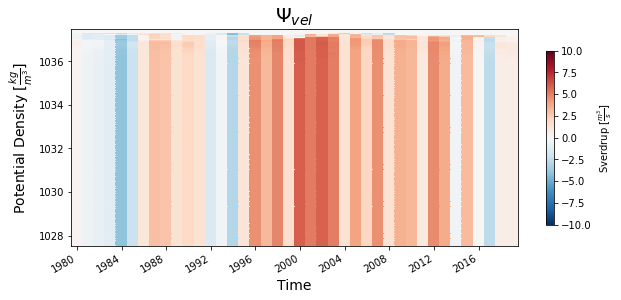

In [98]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
#plt.ylim(1037.3, 1035.5);

(1035.5, 1037.5)

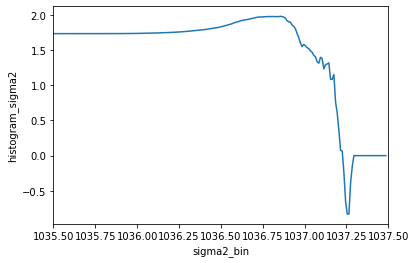

In [102]:
(psi_vel/1e6).mean(dim='time').plot()
plt.xlim(1035.5, 1037.5)

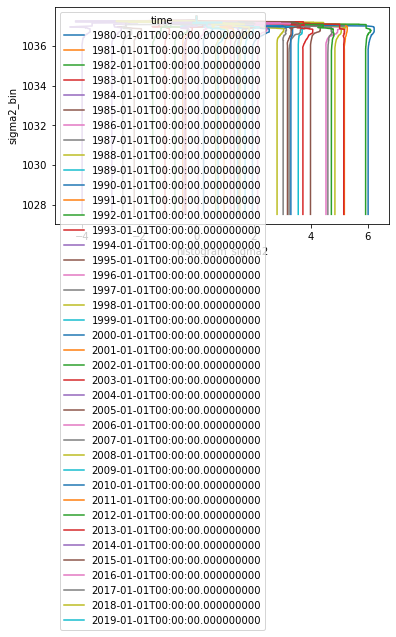

In [106]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin');#, add_legend=True)
#plt.ylim(1037.5, 1035.5);

## NO R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{vel} + \Omega_{surf} + R3 \end{equation*} </font>